## Using Search Algorithms

In [1]:
from overrides import overrides
import torch
from torch import nn
import numpy as np
import json
from typing import Tuple
from random import Random

from typing import Tuple, List, Optional
from archai.discrete_search import ArchaiModel, EvolutionarySearchSpace, BayesOptSearchSpace

**Let's use the search space from the first notebook**

In [2]:
class MyModel(nn.Module):
    def __init__(self, nb_layers: int = 5, kernel_size: int = 3, hidden_dim: int = 32):
        super().__init__()
        
        self.nb_layers = nb_layers
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        
        layer_list = []

        for i in range(nb_layers):
            in_ch = (1 if i == 0 else hidden_dim)
            
            layer_list += [
                nn.Conv2d(in_ch, hidden_dim, kernel_size=kernel_size, padding=(kernel_size-1)//2),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
            ]
            
        layer_list += [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Conv2d(hidden_dim, 10, kernel_size=1)
        ]

        self.model = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.model(x).squeeze()
    
    def get_archid(self):
        return f'({self.nb_layers}, {self.kernel_size}, {self.hidden_dim})'

In [3]:
class CNNSearchSpace(EvolutionarySearchSpace, BayesOptSearchSpace):
    def __init__(self, min_layers: int = 1, max_layers: int = 12,
                 kernel_list=(1, 3, 5, 7), hidden_list=(16, 32, 64, 128),
                 seed: int = 1):

        self.min_layers = min_layers
        self.max_layers = max_layers
        self.kernel_list = kernel_list
        self.hidden_list = hidden_list
        
        self.rng = Random(seed)
        
    @overrides
    def random_sample(self) -> ArchaiModel:
        # Randomly chooses architecture parameters
        nb_layers = self.rng.randint(self.min_layers, self.max_layers)
        kernel_size = self.rng.choice(self.kernel_list)
        hidden_dim = self.rng.choice(self.hidden_list)
        
        model = MyModel(nb_layers, kernel_size, hidden_dim)
        
        # Wraps model into ArchaiModel
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_arch(self, model: ArchaiModel, file: str):
        with open(file, 'w') as fp:
            json.dump({
                'nb_layers': model.arch.nb_layers,
                'kernel_size': model.arch.kernel_size,
                'hidden_dim': model.arch.hidden_dim
            }, fp)

    @overrides
    def load_arch(self, file: str):
        config = json.load(open(file))
        model = MyModel(**config)
        
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_model_weights(self, model: ArchaiModel, file: str):
        state_dict = model.arch.get_state_dict()
        torch.save(state_dict, file)
    
    @overrides
    def load_model_weights(self, model: ArchaiModel, file: str):
        model.arch.load_state_dict(torch.load(file))

    @overrides
    def mutate(self, model_1: ArchaiModel) -> ArchaiModel:
        config = {
            'nb_layers': model_1.arch.nb_layers,
            'kernel_size': model_1.arch.kernel_size,
            'hidden_dim': model_1.arch.hidden_dim
        }
        
        if self.rng.random() < 0.2:
            config['nb_layers'] = self.rng.randint(self.min_layers, self.max_layers)
        
        if self.rng.random() < 0.2:
            config['kernel_size'] = self.rng.choice(self.kernel_list)
        
        if self.rng.random() < 0.2:
            config['hidden_dim'] = self.rng.choice(self.hidden_list)
        
        mutated_model = MyModel(**config)
        
        return ArchaiModel(
            arch=mutated_model, archid=mutated_model.get_archid()
        )
    
    @overrides
    def crossover(self, model_list: List[ArchaiModel]) -> ArchaiModel:
        model_1, model_2 = model_list[:2]
        
        new_config = {
            'nb_layers': self.rng.choice([model_1.arch.nb_layers, model_2.arch.nb_layers]),
            'kernel_size': self.rng.choice([model_1.arch.kernel_size, model_2.arch.kernel_size]),
            'hidden_dim': self.rng.choice([model_1.arch.hidden_dim, model_2.arch.hidden_dim]),
        }
        
        crossover_model = MyModel(**new_config)
        
        return ArchaiModel(
            arch=crossover_model, archid=crossover_model.get_archid()
        )
    
    @overrides
    def encode(self, model: ArchaiModel) -> np.ndarray:
        return np.array([model.arch.nb_layers, model.arch.kernel_size, model.arch.hidden_dim])

In [4]:
ss = CNNSearchSpace(max_layers=10, kernel_list=[3, 5, 7], hidden_list=[32, 64, 128])

In [5]:
m = ss.random_sample()
m

ArchaiModel(
	archid=(3, 7, 32), 
	metadata={}, 
	arch=MyModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
)

### **Dataset**

In [6]:
from pathlib import Path
from archai.cv.datasets.providers.mnist_provider import MnistProvider

In [7]:
dataset_provider = MnistProvider({'dataroot': Path.home() / 'dataroot'})

In [8]:
dataset_provider.get_datasets(True, False, None, None)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /home/pkauffmann/dataroot
     Split: Train,
 None)

### Search objectives

Let's use Partial trainig validation accuracy as a proxy for task performance

In [9]:
from archai.discrete_search import Objective
from archai.discrete_search.objectives.onnx_model import AvgOnnxLatency
from archai.discrete_search.objectives.torch_model import TorchFlops, TorchNumParameters
from archai.discrete_search.objectives.ray import RayParallelObjective

In [10]:
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm
import math

In [11]:
class PartialTrainingValAccuracy(Objective):
    higher_is_better: bool = True

    def __init__(self, training_epochs: float = 1.0, lr: float = 1e-4, device: str = 'cpu',
                 progress_bar: bool = False):
        self.training_epochs = training_epochs
        self.device = device
        self.lr = lr
        self.preprocess = ToTensor()
        self.progress_bar = progress_bar
    
    @overrides
    def evaluate(self, model, dataset_provider, budget = None) -> float:
        # Loads the dataset
        tr_data, _ = dataset_provider.get_datasets(True, False, self.preprocess, None)
        
        # Train-validation split
        tr_data, val_data = torch.utils.data.random_split(
            tr_data, lengths=[len(tr_data) - 1_000, 1_000], 
            generator=torch.Generator().manual_seed(42)
        )
        
        tr_dl = torch.utils.data.DataLoader(tr_data, batch_size=16, shuffle=True, num_workers=4)
        val_dl = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)
        
        # Training settings
        optimizer = torch.optim.Adam(model.arch.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        model.arch.train()
        model.arch.to(self.device)
        
        # Partial training
        epoch_iter = range(math.ceil(self.training_epochs))
        if self.progress_bar:
            epoch_iter = tqdm(epoch_iter, desc=f'Training model {model.archid}')

        for epoch_nb in epoch_iter:
            # Early stops for fractional values of training epochs (e.g, 0.2)
            early_stop = len(tr_dl) + 1
            if 0 < (self.training_epochs - epoch_nb) < 1:
                early_stop = int((self.training_epochs - epoch_nb) * len(tr_dl))
            
            for i, (x, y) in enumerate(tr_dl):
                if i >= early_stop:
                    break
                
                optimizer.zero_grad()
                
                pred = model.arch(x.to(self.device))
                loss = criterion(pred, y.to(self.device))

                loss.backward()
                optimizer.step()
        
        # Evaluates final model
        model.arch.eval()
        
        with torch.no_grad():
            val_pred, val_target = [], []

            for x, y in val_dl:
                val_pred.append(model.arch(x.to(self.device)).argmax(axis=1).to('cpu'))
                val_target.append(y.to('cpu'))

            val_pred, val_target = torch.cat(val_pred, axis=0), torch.cat(val_target, axis=0)
            val_acc = (val_pred.squeeze() == val_target.squeeze()).numpy().mean()

        # Returns model to cpu
        model.arch.cpu()
        
        return val_acc

Let's test our objective:

In [12]:
partial_tr = PartialTrainingValAccuracy(training_epochs=0.001, progress_bar=True)

In [13]:
# NBVAL_IGNORE_OUTPUT
partial_tr.evaluate(ss.random_sample(), dataset_provider)

Training model (5, 3, 64): 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


0.12

We can make this objective run in parallel using the `RayParallelObjective` wrapper, for instance:

In [14]:
parallel_partial_tr = RayParallelObjective(partial_tr)

Now, `partial_tr` is a `archai.discrete_search.AsyncObjective` object. Let's test our partial training objective sending two random architectures

In [15]:
# NBVAL_SKIP
parallel_partial_tr.send(ss.random_sample(), dataset_provider)
parallel_partial_tr.send(ss.random_sample(), dataset_provider)

2022-12-12 13:22:45,865	INFO worker.py:1518 -- Started a local Ray instance.


In [16]:
# NBVAL_SKIP
parallel_partial_tr.fetch_all()

Training model (8, 5, 128): 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[0.12, 0.1]

To run the same objective distributing jobs across multiple GPUs, just set the `num_gpus` parameter from [ray.init](https://docs.ray.io/en/latest/ray-core/package-ref.html#ray-init):

```python
RayParallelObjective(
    PartialTrainingValAccuracy(training_epochs=1),
    num_gpus=0.5, # 2 jobs per gpu available
    max_calls=1
)
```

Now let's wrap up and choose the objective functions we want to optimize

In [17]:
# Search objectives are defined as a dictionary of Objectives
objectives = {
    'Onnx Latency (ms)': AvgOnnxLatency(input_shape=(1, 1, 28, 28), num_trials=3),
    'FLops': TorchFlops(input_shape=(1, 1, 28, 28)),
    
    # To speed evaluation, we'll train multiple models in parallel
    'Partial training Validation Accuracy': RayParallelObjective(
        PartialTrainingValAccuracy(training_epochs=1, device='cuda'),
        num_gpus=0.5, # 2 jobs per gpu available
        max_calls=1
    )
}

### Choosing a search algorithm

Let's try `EvolutionParetoSearch` first

In [18]:
from archai.discrete_search.algos.evolution_pareto import EvolutionParetoSearch

In [19]:
algo = EvolutionParetoSearch(
    search_space=ss, objectives=objectives, dataset_provider=dataset_provider, 
    output_dir='./out_evo2', num_iters=5, num_crossovers=5, mutations_per_parent=2,
    max_unseen_population=15
)

13:23 Using 10 random architectures as the initial population
13:23 starting evolution pareto iter 0
13:23 iter 0: calculating search objectives {'Onnx Latency (ms)': <archai.discrete_search.objectives.onnx_model.AvgOnnxLatency object at 0x7f7204a6f2e0>, 'FLops': <archai.discrete_search.objectives.torch_model.TensorwatchStat object at 0x7f70b3b7d160>, 'Partial training Validation Accuracy': <archai.discrete_search.objectives.ray.RayParallelObjective object at 0x7f7204a6f5b0>} for 10 models
Dispatching jobs for "Partial training Validation Accuracy"...: 100%|███████████████████████████████████| 10/10 [00:00<00:00, 125.44it/s]
Gathering results from async objectives...: 100%|██████████████████████████████████████████████████████████| 1/1 [01:13<00:00, 73.56s/it]
13:24 iter 0: updating the pareto
13:24 iter 0: found 8 members
13:24 iter 0: chose 8 parents
13:24 iter 0: number of parents after objective fn. filter = 8
Mutating parents: 100%|█████████████████████████████████████████████████

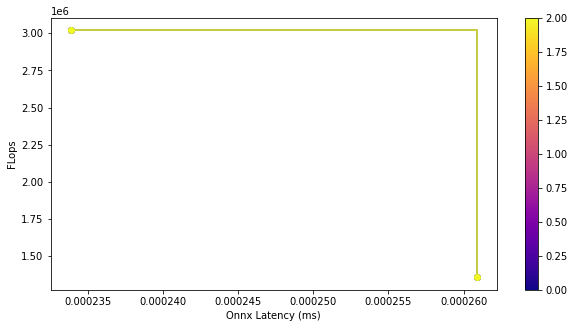

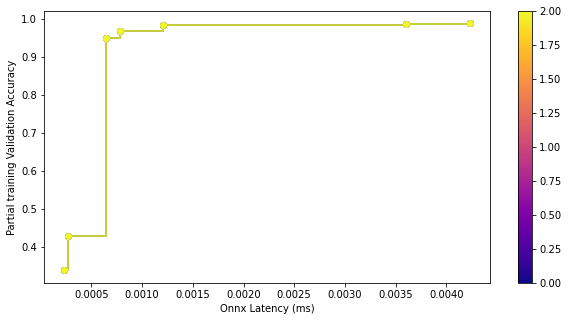

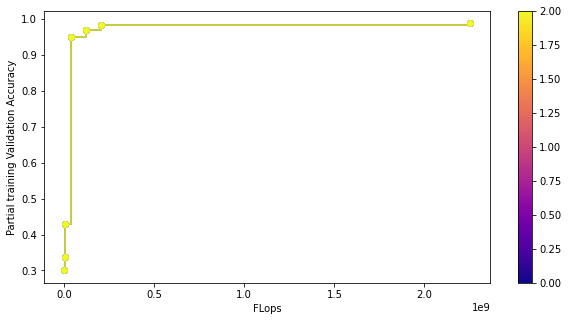

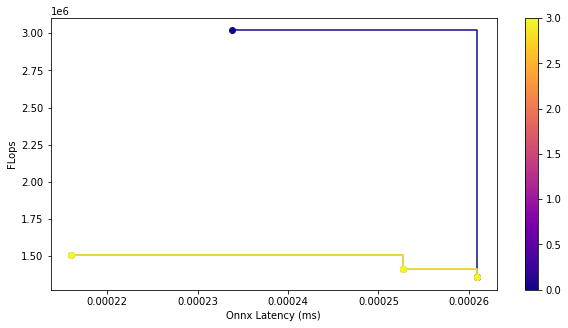

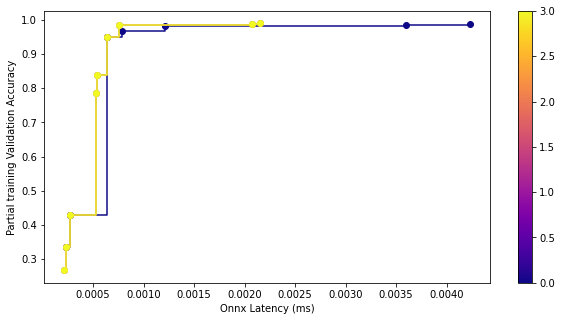

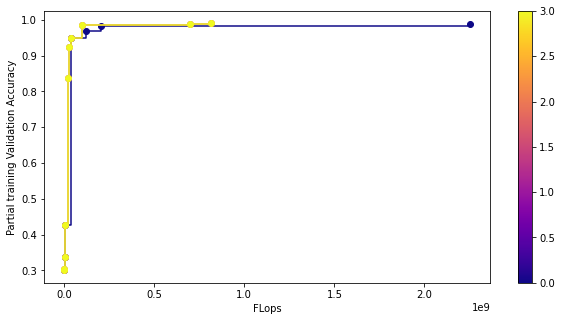

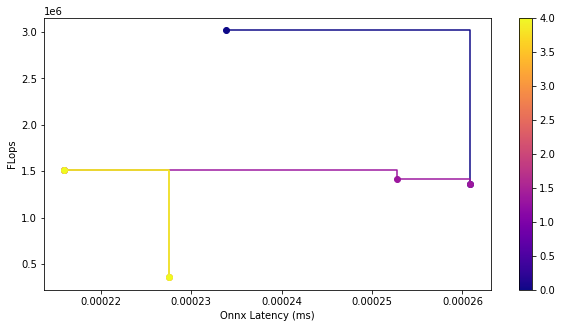

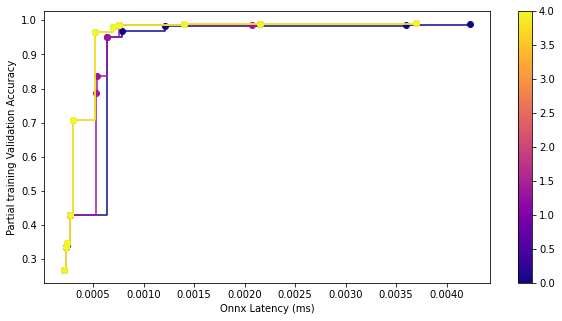

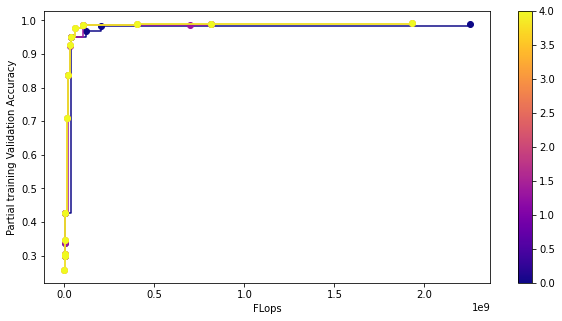

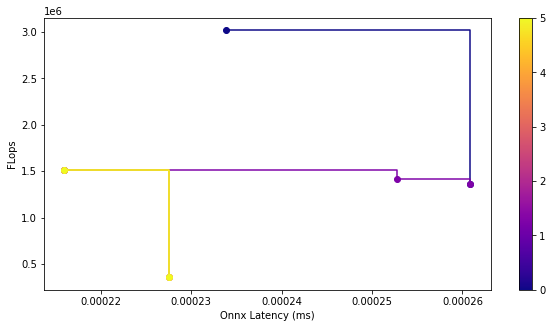

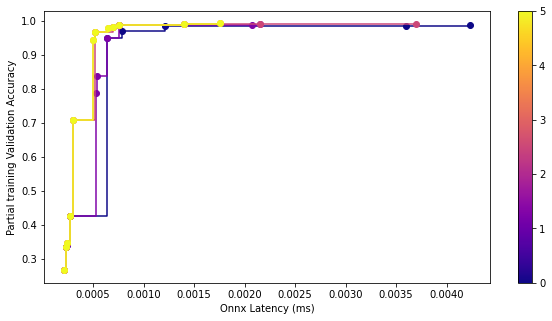

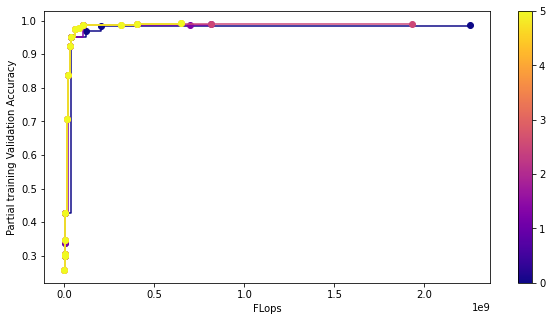

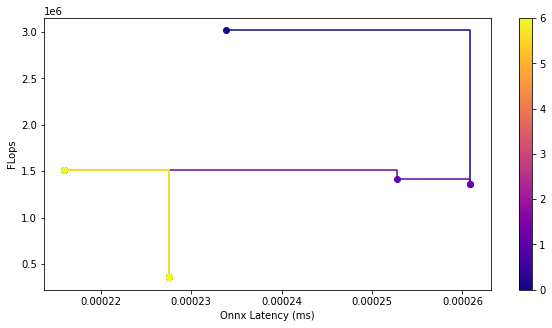

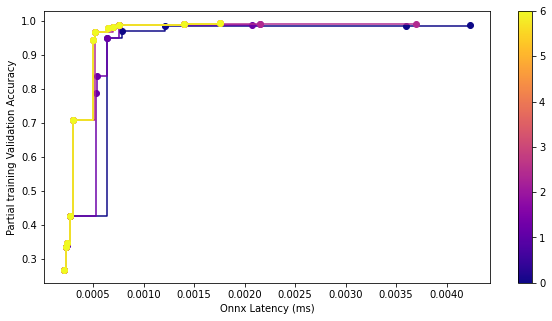

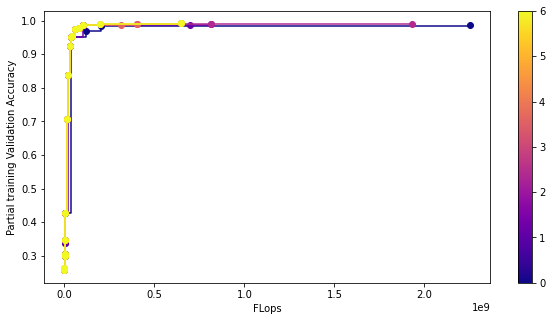

In [20]:
# NBVAL_SKIP
search_results = algo.search()

By default all algorithms will save the final pareto architectures `pareto_models_iter_*/`, pareto evolution plots `pareto_*.png` and search state tables with all the results `search_state_*.csv`

In [21]:
# NBVAL_SKIP
!ls /tmp/out_evo2

log.log
pareto_FLops_vs_Partial_training_Validation_Accuracy.png
pareto_models_iter_1
pareto_models_iter_2
pareto_models_iter_3
pareto_models_iter_4
pareto_models_iter_5
pareto_Onnx_Latency_ms_vs_FLops.png
pareto_Onnx_Latency_ms_vs_Partial_training_Validation_Accuracy.png
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv
search_state_5.csv


You can also get information from the `search_results` object

In [22]:
# NBVAL_SKIP
search_results.get_search_state_df().query('is_pareto').sort_values('Partial training Validation Accuracy')

,archid,Onnx Latency (ms),FLops,Partial training Validation Accuracy,parent,parents,iteration_num,Search walltime (hours),is_pareto
25,"(1, 3, 32)",0.000228,353386.0,0.256,"(1, 3, 128)",None,2,0.072800,True
59,"(1, 5, 32)",0.000288,754794.0,0.264,"(1, 3, 128)",None,4,0.147950,True
23,"(1, 5, 64)",0.000216,1509578.0,0.267,"(1, 5, 128)",None,1,0.048188,True
11,"(1, 3, 128)",0.000253,1413514.0,0.287,None,"(8, 3, 64),(1, 7, 128)",1,0.048188,True
8,"(1, 7, 32)",0.000261,1356906.0,0.300,None,None,0,0.020952,True
10,"(1, 3, 128)",0.000262,1413514.0,0.304,"(1, 7, 128)",None,1,0.048188,True
6,"(1, 5, 128)",0.000234,3019146.0,0.337,None,None,0,0.020952,True
31,"(1, 7, 64)",0.000242,2713802.0,0.348,"(1, 7, 128)",None,2,0.072800,True
5,"(1, 7, 128)",0.000274,5427594.0,0.428,None,None,0,0.020952,True
32,"(3, 3, 32)",0.000305,15004778.0,0.708,"(4, 3, 32)",None,2,0.072800,True


Since our search space is also compatible with Bayesian Optimization algorithms, let's try more sophisticated algorithm like MO-BANANAS

In [23]:
from archai.discrete_search.algos.bananas import MoBananasSearch

In [24]:
algo2 = MoBananasSearch(
    search_space=ss, objectives=objectives, dataset_provider=dataset_provider, 
    output_dir='/tmp/out_bananas', 
    cheap_objectives=['Onnx Latency (ms)', 'FLops'], # Cheap objectives won't be predicted by the surrogate model
    num_iters=5, mutations_per_parent=5, num_mutations=20
)

13:32 Starting iteration 0
13:32 Evaluating objectives for 10 architectures
Dispatching jobs for "Partial training Validation Accuracy"...: 100%|███████████████████████████████████| 10/10 [00:00<00:00, 143.76it/s]
Gathering results from async objectives...: 100%|██████████████████████████████████████████████████████████| 1/1 [01:13<00:00, 73.43s/it]
13:33 Updating surrogate model...
Training DNN Ensemble...: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.17s/it]
/home/pkauffmann/archai/archai/discrete_search/utils/multi_objective.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frontiers = np.array(
13:34 Generating mutations for 10 parent architectures...
13:34 Predicting objectives ['Partial training Valid

13:42 Predicting objectives ['Partial training Validation Accuracy'] using surrogate model
13:42 Calculating cheap objectives ['Onnx Latency (ms)', 'FLops']
Calculating "FLops"...: 100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 142.04it/s]
Gathering results from async objectives...: 0it [00:00, ?it/s]
13:42 20 candidate architectures were selected for the next iteration


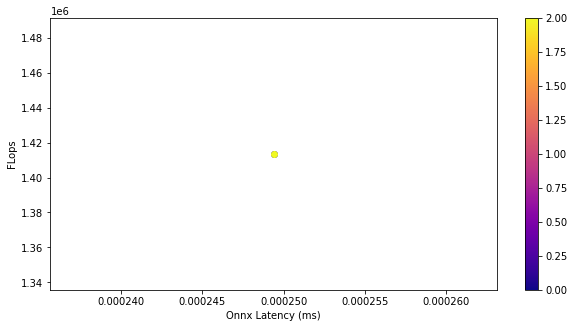

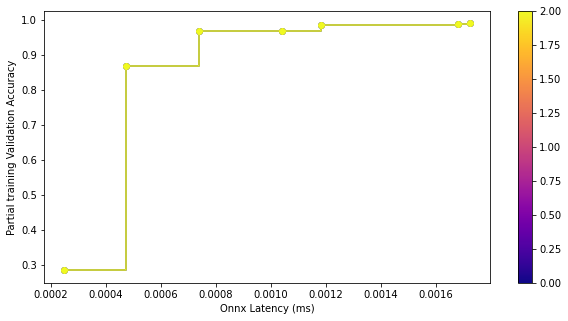

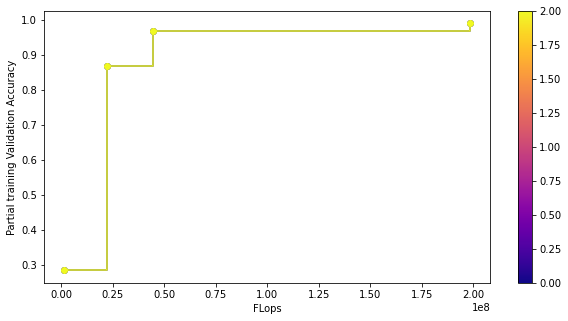

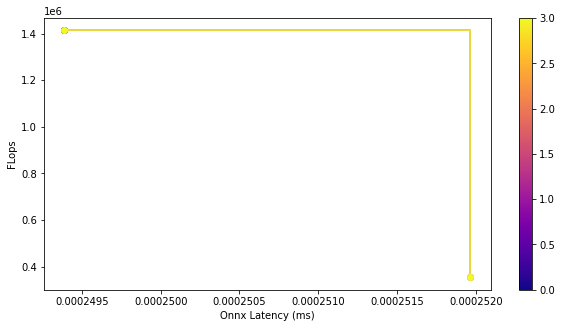

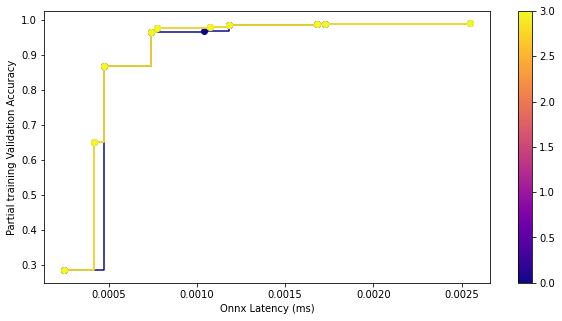

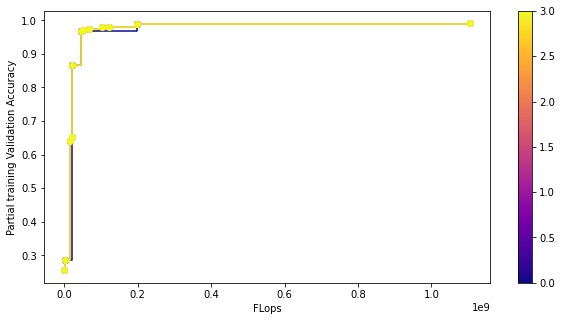

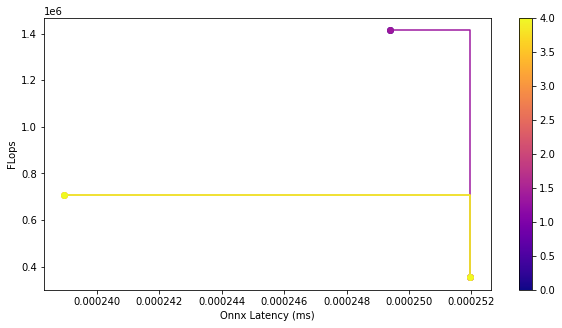

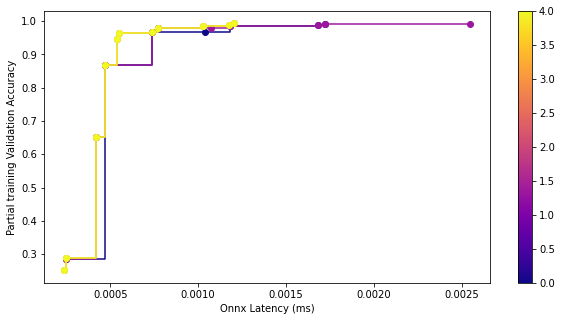

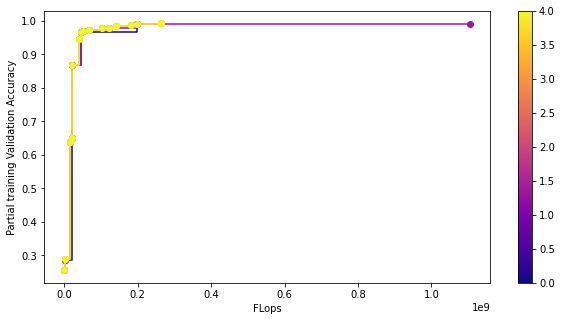

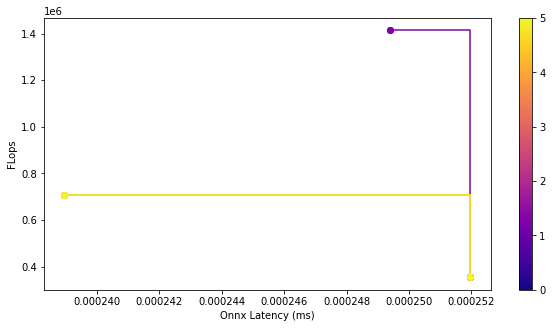

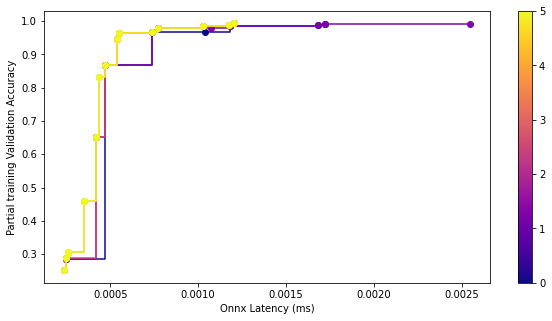

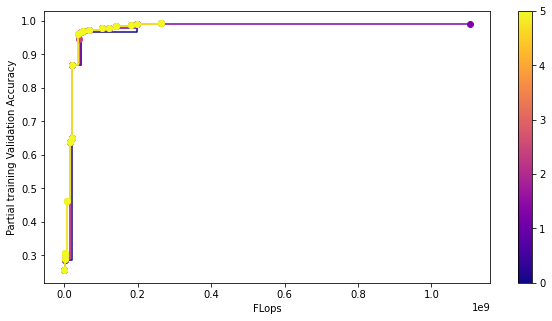

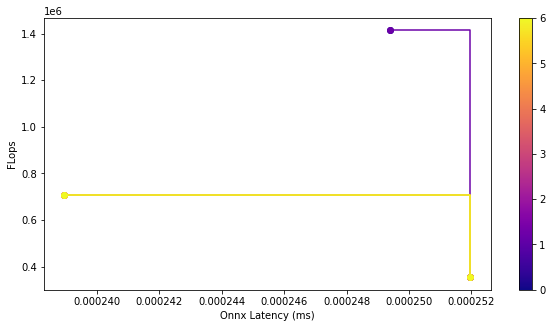

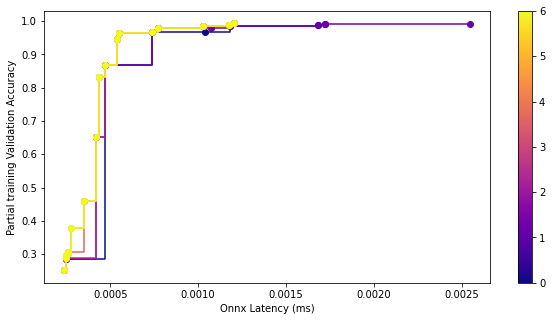

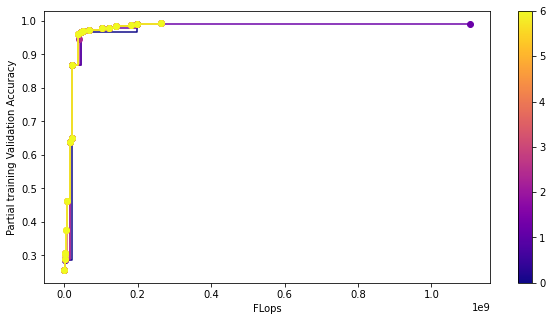

In [25]:
# NBVAL_SKIP
search_results2 = algo2.search()

In [26]:
# NBVAL_SKIP
!ls /tmp/out_bananas

log.log
pareto_FLops_vs_Partial_training_Validation_Accuracy.png
pareto_Onnx_Latency_ms_vs_FLops.png
pareto_Onnx_Latency_ms_vs_Partial_training_Validation_Accuracy.png
search_state_0.csv
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv


MO-BANANAS will also save the predictive mean and variance of the expensive objectives (in this case `Predicted Partial training Validation Accuracy`).

In [27]:
# NBVAL_SKIP
search_results2.get_search_state_df().query('is_pareto').sort_values('Partial training Validation Accuracy')

,archid,Onnx Latency (ms),FLops,Partial training Validation Accuracy,iteration_num,Predicted Partial training Validation Accuracy mean,Predicted Partial training Validation Accuracy var,Search walltime (hours),is_pareto
28,"(1, 3, 64)",0.000239,706762.0,0.251,2,0.313004,0.000360,0.105893,True
10,"(1, 3, 32)",0.000252,353386.0,0.255,1,0.602352,0.005347,0.070371,True
29,"(1, 5, 32)",0.000245,754794.0,0.289,2,0.457042,0.001704,0.105893,True
54,"(1, 5, 64)",0.000246,1509578.0,0.296,4,0.397546,0.002552,0.153856,True
44,"(1, 7, 32)",0.000262,1356906.0,0.303,3,0.698000,0.011878,0.130883,True
43,"(1, 5, 128)",0.000262,3019146.0,0.307,3,0.617455,0.002025,0.130883,True
53,"(1, 7, 128)",0.000278,5427594.0,0.377,4,0.536954,0.001538,0.153856,True
49,"(2, 3, 32)",0.000349,7679082.0,0.461,3,0.448850,0.000029,0.130883,True
11,"(3, 3, 32)",0.000466,15004778.0,0.640,1,0.773703,0.000529,0.070371,True
12,"(2, 5, 32)",0.000419,20925546.0,0.651,1,0.873010,0.001508,0.070371,True
